# Imports

In [82]:
import random
import psycopg2
from calendar import monthrange
import requests
import time
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import pandas as pd
import numpy as np
import time
import math
import copy
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
from datetime import datetime
%matplotlib inline 
plt.style.use('fivethirtyeight')

# Make connection to PSQL database

In [83]:
connection = psycopg2.connect(user="postgres",
                              password="@#bedrock$203",
                              host="1.7.151.13",
                              port="5432",
                              database="cosmosis")

## Precautions for web issues

In [84]:
def GET_UA():
    uastrings = ["Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.111 Safari/537.36",\
                "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/28.0.1500.72 Safari/537.36",\
                "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10) AppleWebKit/600.1.25 (KHTML, like Gecko) Version/8.0 Safari/600.1.25",\
                "Mozilla/5.0 (Windows NT 6.1; WOW64; rv:33.0) Gecko/20100101 Firefox/33.0",\
                "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.111 Safari/537.36",\
                "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.111 Safari/537.36",\
                "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5) AppleWebKit/600.1.17 (KHTML, like Gecko) Version/7.1 Safari/537.85.10",\
                "Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko",\
                "Mozilla/5.0 (Windows NT 6.3; WOW64; rv:33.0) Gecko/20100101 Firefox/33.0",\
                "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.104 Safari/537.36"\
                ]
    return random.choice(uastrings)

## Get Regions' details

In [85]:
def getRegions(connection):
    print('getting list of Regions')
    cursor = connection.cursor()
    postgreSQL_select_Query = "select id,region_name,region_api from public.data_region"
    cursor.execute(postgreSQL_select_Query)
    regions = cursor.fetchall()
    return regions
def getObs(connection,region_id,year):
#     print('getting Observaratory based on regionid'+str(region_id))
    cursor = connection.cursor()
    postgreSQL_select_Query = "select code,station_name,year,id,lat,lon FROM public.data_observatory where year="+str(year)+" and region_id="+str(region_id)
    cursor.execute(postgreSQL_select_Query)
    regions = cursor.fetchall()
    return regions

# Get the regional code of closest observatory

In [86]:
def get_obs(oobs, lat, lon):
    
    dist = 360
    code = ''
    cname = ''
    for i in oobs:
        x, y = lon, lat
        x1, y1 = i[5], i[4]
        temp = math.sqrt((x-x1)**2 + (y-y1)**2)
#         print(temp, i[0])
        if temp < dist:
            dist = temp
            code = i[0]
            cname = i[1]
    if code == '':
        print('Cannot Access Region Code')
    else:
        return code, cname

# Get Data from observatory (within the hour)

In [87]:
def getData(year,month,day,hour,minute,code):
    final_data = []
    in_hour_data = []
    try:
        session = requests.Session()
        retry = Retry(connect=5, backoff_factor=0.5)
        adapter = HTTPAdapter(max_retries=retry)
        session.mount('http://', adapter)
        session.mount('https://', adapter)
        headers = {'User-Agent': GET_UA()}   
        URL = "https://intermagnet.org/data-donnee/dataplot-1-eng.php?year="+str(year)+"&month="+str(month)+"&day="+str(day)+"&start_hour="+str(hour)+"&end_hour="+str(hour+1)+"&filter_region%5B%5D=America&filter_region%5B%5D=Asia&filter_region%5B%5D=Europe&filter_region%5B%5D=Pacific&filter_region%5B%5D=Africa&filter_lat%5B%5D=NH&filter_lat%5B%5D=NM&filter_lat%5B%5D=E&filter_lat%5B%5D=SM&filter_lat%5B%5D=SH&sort=iaga&iaga_code="+code+"&type=xyz&fixed_scale=1&format=html"
        r =  session.get(URL, headers=headers) 
        soup = BeautifulSoup(r.content, 'html.parser')
        table = soup.find(lambda tag: tag.name=='table')
        time_s = []
        for tt in [year, month, day, hour, minute]:
            if(tt<10):
                temp = '0'+str(tt)
            else:
                temp = str(tt)
            time_s.append(temp)
        time_check = time_s[0]+'-'+time_s[1]+'-'+time_s[2]+' '+time_s[3]+':'+time_s[4]+':00'
#         print(time_check)
        try:
            rows = table.findAll(lambda tag: tag.name=='tr')
            for row in rows:
                cols = row.findAll('td')
                try :
                    if (cols[0]!=None):
                        if(str(cols[0].text) == time_check):
#                             print(time_check)
                            final_data.extend([str(cols[0].text),cols[1].text,cols[2].text,cols[3].text,cols[4].text, code])
                        in_hour_data.append([cols[0].text,cols[1].text,cols[2].text,cols[3].text,cols[4].text,code])

                except Exception as err:
                    print(err)
                    pass
            return final_data, in_hour_data
#             print("Data Saved")
        except:
            print('Data not present')
            pass
    except requests.exceptions.RequestException as e:
        print(e)
        time.sleep(300)
    except requests.ConnectionError as e:
        print("OOPS!! Connection Error. Make sure you are connected to Internet. Technical Details given below.\n")
        print(str(e))            
        renewIPadress()       
    except requests.Timeout as e:
        print("OOPS!! Timeout Error")
        print(str(e))
        renewIPadress()       
    except requests.RequestException as e:
        print("OOPS!! General Error")
        print(str(e))
        renewIPadress()
    except KeyboardInterrupt:
        print("Someone closed the program") 

# main Function

In [88]:
def get_magnetic_data(latitude, longitude, year, month, day, hour, minute):
    regions=getRegions(connection)
    oobs = [] 
    for region in regions:

        region_id=region[0]
        region_name=region[1]
        region_api=region[2]
        obs=getObs(connection, region_id, year) 
        for ob in obs:
            code=ob[0]
            ob_name=ob[1]
            year=ob[2]
            obj_id=ob[3]
            lat=float(ob[4])
            if (float(ob[5])>180):
                lon = float(ob[5]) - 360
            else:
                lon=float(ob[5])
            oobs.append([code, ob_name, year, obj_id, lat, lon])
    code, obname = get_obs(oobs, latitude, longitude)
    datass, hour_data = getData(year,month,day,hour,minute,code)

    hour_data = pd.DataFrame(hour_data, columns = ['DateTime', 'Xn(T)', 'Yn(T)', 'Zn(T)', 'Fn(T)', 'code'])
    # print(hour_data.head(10))
    
    # Plot Data 
    x_axis = hour_data['DateTime']
    x = []
    for i in x_axis:
        x.append(datetime.fromisoformat(i))
    y = []
    labels = ['Xn(T)', 'Yn(T)', 'Zn(T)', 'Fn(T)']
    for i in labels:
        temp = hour_data[i]
        temp = temp.astype('float64')
        y.append(temp)
    fig, ax = plt.subplots(nrows = 4, ncols = 1)
    date_format = mpl_dates.DateFormatter('%H:%M')
    st = fig.suptitle('Data from '+obname+' observatory')
    st.set_y(1.01)
    for i in range(4):
        ax[i].plot(x, y[i], linewidth = 1)
        ax[i].plot(datetime.fromisoformat(datass[0]), float(datass[i+1]), 'ro');
        ax[i].text(datetime.fromisoformat(datass[0]), float(datass[i+1]), " - "+labels[i]+"="+str(datass[i+1]))
        ax[i].xaxis.set_major_formatter(date_format)
        ax[i].set_ylabel(labels[i], rotation = 0, labelpad=30, fontsize=15)
    plt.xlabel('Observation time (within the hour)' )
    fig.set_size_inches(12, 8)
    fig.tight_layout()
    plt.show()

# for item in hour_data:
#     print(item)
# hour_data.dtypes

## Test the function

getting list of Regions
list index out of range


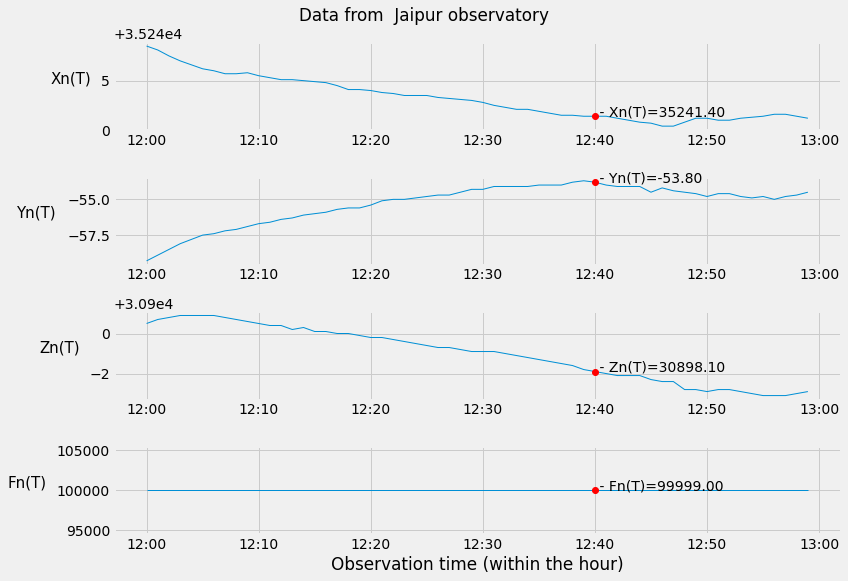

In [89]:
year = 2011
month = 9
day = 18
hour = 12
minute = 40
latitude = 27.3314
longitude = 88.6138


get_magnetic_data(latitude, longitude, year, month, day, hour, minute)

In [5]:
ob = pd.read_csv('note1.csv')
ob_list = ob['code']
for i in ob_list:
    print(i)

ABG
ABK
AIA
AMS
API
ARS
ASC
ASP
BDV
BEL
BFO
BLC
BMT
BOU
BOX
BRD
BRW
BSL
CBB
CKI
CLF
CMO
CNB
CPL
CSY
CYG
CZT
DED
DLT
DMC
DOU
DRV
DUR
EBR
ESK
EYR
FCC
FRD
FRN
FUR
GAN
GCK
GDH
GNG
GUA
GUI
HAD
HBK
HER
HLP
HON
HRB
HRN
HUA
HYB
IPM
IQA
IRT
IZN
JAI
JCO
KAK
KDU
KEP
KHB
KMH
KNY
KOU
LER
LON
LRM
LVV
LYC
MAB
MAW
MCQ
MEA
MGD
MMB
NAQ
NEW
NGK
NUR
NVS
ORC
OTT
PAG
PEG
PET
PHU
PIL
PPT
PST
RES
SBA
SBL
SFS
SHE
SHU
SIT
SJG
SOD
SON
SPG
SPT
STJ
SUA
TAM
TDC
THL
THY
TSU
TTB
TUC
UPS
VAL
VIC
VNA
VOS
VSS
WIC
WNG
YAK


In [ ]:
print(timespan/60)

In [ ]:
print(((11*365)/60)/24)

In [6]:
data_o = pd.read_csv("note1.csv")
data_o

,code,obs_name,coordinates
0,ABG,Alibag,18.62/72.87
1,ABK,Abisko,68.358/18.823
2,AIA,Argentine Islands (Akademik Vernadsky base),-65.25/295.75
3,AMS,Martin de Vivies-Amsterdam Island,-37.8/77.57
4,API,Apia,-13.8/188.22
...,...,...,...
118,VOS,Vostok,-78.464/106.835
119,VSS,Vassouras,-22.4/316.35
120,WIC,Conrad Observatory,47.9305/15.8657
121,WNG,Wingst,53.74/9.07


In [7]:
oobs = data_o.values.tolist()
for obs in oobs:
    obs[2] = obs[2].split('/')
    obs[2][0], obs[2][1] = float(obs[2][0]), float(obs[2][1])
    if obs[2][1]>180:
        obs[2][1] = obs[2][1] - 360
oobs

[['ABG', ' Alibag', [18.62, 72.87]],
 ['ABK', ' Abisko', [68.358, 18.823]],
 ['AIA', ' Argentine Islands (Akademik Vernadsky base)', [-65.25, -64.25]],
 ['AMS', ' Martin de Vivies-Amsterdam Island', [-37.8, 77.57]],
 ['API', ' Apia', [-13.8, -171.78]],
 ['ARS', ' Arti', [56.433, 58.567]],
 ['ASC', ' Ascension Island', [-7.95, -14.379999999999995]],
 ['ASP', ' Alice Springs', [-23.77, 133.88]],
 ['BDV', ' Budkov', [49.08, 14.02]],
 ['BEL', ' Belsk', [51.836, 20.789]],
 ['BFO', ' Black Forest', [48.331, 8.325]],
 ['BLC', ' Baker Lake', [64.318, -96.012]],
 ['BMT', ' Beijing Ming Tombs', [40.3, 116.2]],
 ['BOU', ' Boulder', [40.14, -105.24000000000001]],
 ['BOX', ' Borok', [58.07, 38.23]],
 ['BRD', ' Brandon', [49.87, -99.97390000000001]],
 ['BRW', ' Barrow', [71.32, -156.62]],
 ['BSL', ' Stennis Space Center', [30.35, -89.63999999999999]],
 ['CBB', ' Cambridge Bay', [69.123, -105.031]],
 ['CKI', ' Cocos-Keeling Islands', [-12.1875, 96.8336]],
 ['CLF', ' Chambon la Foret', [48.02, 2.27]],

In [8]:
oobs[100][1]

' San Juan'

[['BLC', ' Baker Lake', 2019, 2824, 64.318, -96.012],
 ['BOU', ' Boulder', 2019, 2825, 40.14, -105.24000000000001],
 ['BRD', ' Brandon', 2019, 2826, 49.87, -99.97390000000001],
 ['BRW', ' Barrow', 2019, 2827, 71.32, -156.62],
 ['BSL', ' Stennis Space Center', 2019, 2828, 30.35, -89.63999999999999],
 ['CBB', ' Cambridge Bay', 2019, 2829, 69.123, -105.031],
 ['CMO', ' College', 2019, 2830, 64.87, -147.86],
 ['DED', ' Deadhorse', 2019, 2831, 70.36, -148.79],
 ['FCC', ' Fort Churchill', 2019, 2832, 58.759, -94.08800000000002],
 ['FRD', ' Fredericksburg', 2019, 2833, 38.2, -77.37],
 ['FRN', ' Fresno', 2019, 2834, 37.09, -119.72],
 ['GDH', ' Qeqertarsuaq (Godhavn)', 2019, 2835, 69.252, -53.533000000000015],
 ['HUA', ' Huancayo', 2019, 2836, -12.05, -75.32999999999998],
 ['IQA', ' Iqaluit', 2019, 2837, 63.753, -68.51799999999997],
 ['JCO', ' Jim Carrigan Observatory', 2019, 2838, 70.356, -148.799],
 ['KEP', ' King Edward Point', 2019, 2839, -54.2821, -36.49290000000002],
 ['KOU', ' Kourou', 2

In [12]:
def sortss(oobs):
    arr = copy.deepcopy(oobs)
    for i in range(len(arr)-1):
        for j in range(len(arr)-i-1):
            if(arr[j][4]>arr[j+1][4]):
                arr[j], arr[j+1] = arr[j+1], arr[j]
    return arr


In [52]:
arr = sortss(oobs)

In [53]:
c = 0
for i in arr:
    c+=1
    print(i[0], i[4], i[5])
print(c)

VOS -78.464 106.835
SBA -77.85 166.78
DMC -75.25 124.167
VNA -70.683 -8.281999999999982
MAW -67.6 62.88
DRV -66.67 140.01
CSY -66.283 110.533
AIA -65.25 -64.25
ORC -60.737 -44.74000000000001
MCQ -54.5 158.95
KEP -54.2821 -36.49290000000002
PST -51.7 -57.889999999999986
PAF -49.35 70.26
CZT -46.43 51.87
EYR -43.474 172.393
AMS -37.8 77.57
CNB -35.32 149.36
HER -34.43 19.23
PIL -31.4 -63.879999999999995
GNG -31.356 115.715
KMH -26.54 18.11
HBK -25.88 27.71
ASP -23.77 133.88
VSS -22.4 -43.64999999999998
LRM -22.22 114.1
CTA -20.1 146.3
TSU -19.202 17.584
PPT -17.57 -149.58
API -13.8 -171.78
KDU -12.69 132.47
CKI -12.1875 96.8336
HUA -12.05 -75.32999999999998
ASC -7.95 -14.379999999999995
KOU 5.21 -52.73000000000002
DLT 11.94 108.48
GUA 13.59 144.87
HYB 17.4 78.6
SJG 18.11 -66.14999999999998
ABG 18.62 72.87
PHU 21.03 105.95
HON 21.32 -158.0
TAM 22.79 5.53
SON 25.1168 66.4487
JAI 26.92 75.8
GUI 28.32 -16.430000000000007
BSL 30.35 -89.63999999999999
KNY 31.42 130.88
TUC 32.18 -110.7299999999

In [27]:
math.sqrt((27.3314-12.05)**2 + (88.6138-75.32999999999998)**2)

20.247975908717404

In [28]:
# -25.88, -75.55200000000002
math.sqrt((27.3314-23.77)**2 + (88.6138-75.55200000000002)**2)

13.142190882801824

In [30]:
# -49.35, -75.32999999999998
math.sqrt((27.3314-49.35)**2 + (88.6138-75.32999999999998)**2)

25.715327888245962

In [30]:
x_axis = hour_data['DateTime']
x = []
for i in x_axis:
    x.append(datetime.fromisoformat(i))
    
y = []
labels = ['Xn(T)', 'Yn(T)', 'Zn(T)', 'Fn(T)']
for i in labels:
    temp = hour_data[i]
    temp = temp.astype('float64')
    y.append(temp)
# ymin = y[0]
# ymax = y[0]
# for i in range(1, len(y)):
#     if (y[i]<ymin):
#         ymin = y[i]
#     if (y[i]>ymax):
#         ymax = y[i]
# N = 6

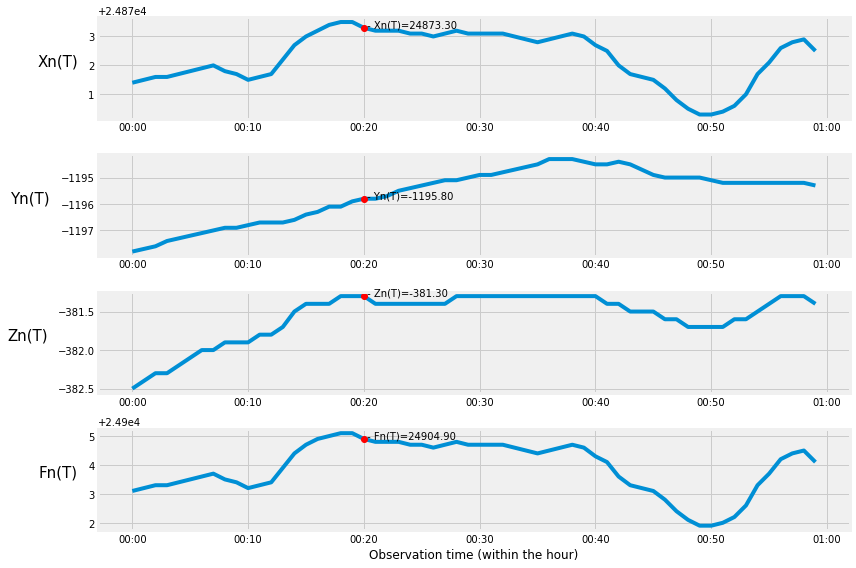

In [44]:
fig, ax = plt.subplots(nrows = 4, ncols = 1)
date_format = mpl_dates.DateFormatter('%H:%M')

for i in range(4):
    ax[i].plot(x, y[i])
    ax[i].plot(datetime.fromisoformat(datass[0]), float(datass[i+1]), 'ro');
    ax[i].text(datetime.fromisoformat(datass[0]), float(datass[i+1]), " - "+labels[i]+"="+str(datass[i+1]))
    ax[i].xaxis.set_major_formatter(date_format)
    ax[i].set_ylabel(labels[i], rotation = 0, labelpad=30, fontsize=15)
plt.xlabel('Observation time (within the hour)' )
fig.set_size_inches(12, 8)
fig.tight_layout()
plt.show()

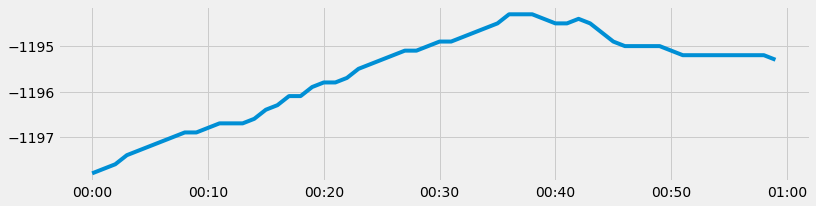

In [32]:
plt.plot(x, y)
date_format = mpl_dates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(date_format)
fig = plt.gcf()
fig.set_size_inches(12, 3)
# custom_ticks = np.linspace(ymin, ymax, N, dtype=int)
# plt.set_yticks(custom_ticks);
# plt.set_yticklabels(custom_ticks);

In [88]:

from datetime import datetime
print (datetime.fromisoformat(x_axis[0]))
# datetime_object = datetime.strptime(, '%Y-%b-%d %I:%M:%S')#'%b %d %Y %I:%M%p'

2019-01-01 00:00:00


In [122]:
y_axis


0     -1197.80
1     -1197.70
2     -1197.60
3     -1197.40
4     -1197.30
5     -1197.20
6     -1197.10
7     -1197.00
8     -1196.90
9     -1196.90
10    -1196.80
11    -1196.70
12    -1196.70
13    -1196.70
14    -1196.60
15    -1196.40
16    -1196.30
17    -1196.10
18    -1196.10
19    -1195.90
20    -1195.80
21    -1195.80
22    -1195.70
23    -1195.50
24    -1195.40
25    -1195.30
26    -1195.20
27    -1195.10
28    -1195.10
29    -1195.00
30    -1194.90
31    -1194.90
32    -1194.80
33    -1194.70
34    -1194.60
35    -1194.50
36    -1194.30
37    -1194.30
38    -1194.30
39    -1194.40
40    -1194.50
41    -1194.50
42    -1194.40
43    -1194.50
44    -1194.70
45    -1194.90
46    -1195.00
47    -1195.00
48    -1195.00
49    -1195.00
50    -1195.10
51    -1195.20
52    -1195.20
53    -1195.20
54    -1195.20
55    -1195.20
56    -1195.20
57    -1195.20
58    -1195.20
59    -1195.30
Name: Yn(T), dtype: object